In [335]:
%matplotlib inline
import scipy
import sympy
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from modsim import*

condition = Condition(R = 51, #
                      L = 25, #220 * (10 ** (-6))
                      C0 = 220 * (10 ** (-3)), 
                      V0 = 5,
                      dV0dt = 0,
                      f0 = 1073.02, 
                      w0 = 1)

# Do research of temp dependance of L and C

In [336]:
duration = 120

dt = 1

ts = linrange(0, duration, dt)

In [337]:
def make_system(condition):
    
    unpack(condition)
    
    init = State(X1 = V0, X2 = dV0dt)
    
    system = System(init=init, R=R, L=L, C0=C0, V0=V0, dV0dt=dV0dt, f0=f0, w0=w0, ts=ts)
    
    return system
                    
    
circuit = make_system(condition)

In [338]:
def slope_func(state, t, circuit):
    
    X1, X2 = state
    unpack(circuit)
    
    dX1dt = X2
    # dX2dt = ((L/R*C0) * (V0*np.degrees(np.sin(w0*t))) - ((1/R*L*C0)*X1) - ((1/L)*X2))
    # Used w0 in radians to get better results
    dX2dt = ((L/R*C0) * (V0*math.sin((w0)*t)) - ((1/R*L*C0)*X1) - ((1/L)*X2)) 
    
    return dX1dt, dX2dt

slope_func(circuit.init, 0, circuit) # Testing

(0.0, -0.53921568627450978)

In [339]:
run_odeint(circuit, slope_func)

# circuit.results

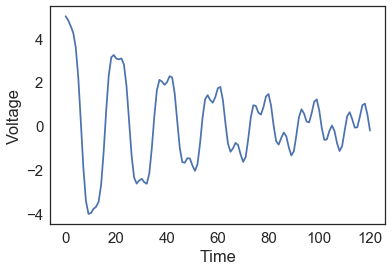

In [340]:
X1 = circuit.results.X1 # voltage
X2 = circuit.results.X2 # first derivative
X3 = (X2.diff()/dt) # second derivative
plt.plot(ts, X1)
#plot(ts, X1, '.')
xlabel("Time")
ylabel("Voltage")

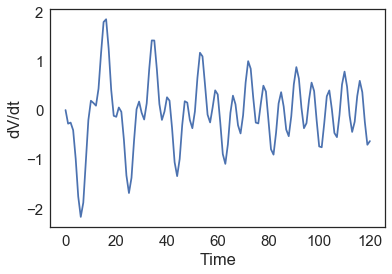

In [341]:
plt.plot(ts, X2)
xlabel("Time")
ylabel("dV/dt")

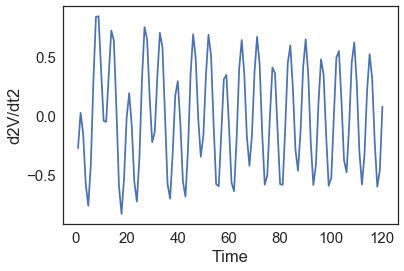

In [342]:
plt.plot(ts, X3)
xlabel("Time")
ylabel("d2V/dt2")

In [343]:
def getAmp(X3, ts):
    
    min = 10000
    max = -5
    
    for i in range(len(X3)):
        
        t = ts[i]
        x = X3[i]
        
        if t > 60 and t < 120:
            
            if x > max:
                max = x
            
            if x < min:
                min = x
                
    Amp = (max - min)
    
    return Amp    

In [344]:
getAmp(X3, ts)

1.3138736944842819

In [345]:
def run_simulation(w0):
    
    condition.w0 = w0
    #print(condition)
    
    circuit = make_system(condition)
    run_odeint(circuit, slope_func)
    X3 = (circuit.results.X2.diff()/dt)
    amp = getAmp(X3, ts)
    
    return amp
    

In [354]:
def loopy_boi():
    
    # w0_array = linspace(6, 13, 100) # 0 to 10 for the glitch
    C_array = linspace((1.6367 * math.exp(-18)), (1.6367 * math.exp(-18)), 100)
    w0_array = 1 / (sqrt(L * C_array))
    
    amps = []
    for w0 in w0_array:
        #print(w0_array)
        amp = run_simulation(w0)
        amps.append(amp)
        #print(amp)
    print(w0_array)    
    return (w0_array, amps)

In [355]:
(w0_array, amp_array) = loopy_boi()
#print(amp_array)

C:\ProgramData\Miniconda3\lib\site-packages\scipy\integrate\odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[ 1266.76423005  1266.76423005  1266.76423005  1266.76423005  1266.76423005
  1266.76423005  1266.76423005  1266.76423005  1266.76423005  1266.76423005
  1266.76423005  1266.76423005  1266.76423005  1266.76423005  1266.76423005
  1266.76423005  1266.76423005  1266.76423005  1266.76423005  1266.76423005
  1266.76423005  1266.76423005  1266.76423005  1266.76423005  1266.76423005
  1266.76423005  1266.76423005  1266.76423005  1266.76423005  1266.76423005
  1266.76423005  1266.76423005  1266.76423005  1266.76423005  1266.76423005
  1266.76423005  1266.76423005  1266.76423005  1266.76423005  1266.76423005
  1266.76423005  1266.76423005  1266.76423005  1266.76423005  1266.76423005
  1266.76423005  1266.76423005  1266.76423005  1266.76423005  1266.76423005
  1266.76423005  1266.76423005  1266.76423005  1266.76423005  1266.76423005
  1266.76423005  1266.76423005  1266.76423005  1266.76423005  1266.76423005
  1266.76423005  1266.76423005  1266.76423005  1266.76423005  1266.76423005
  1266.76423

In [348]:
Frequency = 2*pi*w0_array # Hz = 2 * pi * rad
Amplitude = amp_array/V0 # Normalizing Amp

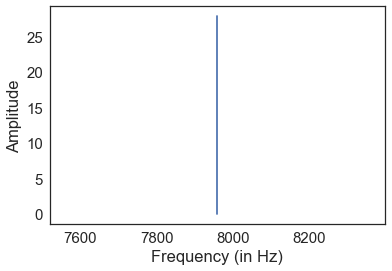

In [349]:
plt.plot(Frequency, Amplitude) 
#plot(w0_array, amp_array, '.')
xlabel("Frequency (in Hz)")
ylabel("Amplitude")
#savefig('FreqinMHz-AmpdivAmp-Bode.pdf')
#print(amp_array)

In [210]:
#w0_array[amp_array.index(0.093995685536970852)]

'When I ran ODEINT with all the values of w0, it gave me a rogue datapoint. I went in and ran ODEINT for that particular\n    datapoint and then ODEINT gave a different, valid datapoint for that particular point. So that means ODEINT is not\n    behaving properly when I run multiple iterations of w0 through it.'

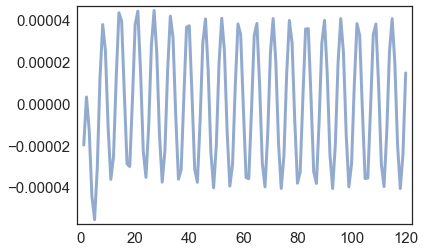

In [211]:
condition.w0 = 3.131313131313131
slope_func(circuit.init, 0, circuit)
run_odeint(circuit, slope_func)

X1 = circuit.results.X1 # voltage
X2 = circuit.results.X2 # first derivative
X3 = (X2.diff()/dt) # second derivative

plot(ts, X3)
getAmp(X3, ts)

"""When I ran ODEINT with all the values of w0, it gave me a rogue datapoint. I went in and ran ODEINT for that particular
    datapoint and then ODEINT gave a different, valid datapoint for that particular point. So that means ODEINT is not
    behaving properly when I run multiple iterations of w0 through it."""

In [92]:
# DO NOT EVER RUN THIS CELL
#goodRunW0 = w0_array
#goodRunAmp = amp_array

goodRun = pd.Series(goodRunAmp, index=goodRunW0)
goodRun.to_csv("goodrun.csv")
#plt.plot(goodRunW0, goodRunAmp)
plot(goodRun)

NameError: name 'goodRunAmp' is not defined

In [ ]:
def loopy_boi(condition, system, slope_func):
    
    w0_array = linrange(1, 2, 10)

    w0_frame = []

    for w0 in w0_array:

        #condition = Condition(R = 51, L = 4, C0 = 220 * (10 ** (-3)), V0 = 5, dV0dt = 0, f0 = 1073.02, w0 = 1)
        condition.w0 = (w0)
        circuit = make_system(condition)
        slope_func(circuit.init, 0, circuit)
        run_odeint(circuit, slope_func)
        w0_frame.append(X3)
        
        return w0_frame

        #circuit.results

In [ ]:
loopy_boi(condition, circuit, slope_func)